# Introduction

Hey there! This is Cristian Piacente.

This Jupyter notebook was created for the Challenge 1 by xtream.

It's about a regression task. We need to be the new diamond evaluator, our job is to predict a gem's price (in USD) based on


*   carat - weight of the diamond (= 200 mg)
*   cut - quality of the cut (light performance), it can be Fair (worst), Good, Very Good, Premium, Ideal (best)
*   color - diamond color, it can be D (worst), E, F, G, H, I, J, ..., Z (best)
*   clarity - how clear the diamond is, it can be I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best)
*   depth - z depth / z * 100
*   table - table width / x * 100
*   x - diamond length (mm)
*   y - diamond width (mm)
*   z - diamond depth (mm)



This Jupyter notebook was written and tested on Google Colab, that's why there is a block below for downloading the csv: you can skip it if using the notebook locally.

Let the journey begin!


# Download the dataset (just for simplifying Google Colab support)

In [1]:
# Download the dataset from my GitHub fork,
# to use it for this Google Colab session

# Not needed if run locally with the csv ready

!mkdir -p ./datasets/diamonds/
!wget https://raw.githubusercontent.com/cristianpiacente01/xtream-ai-assignment-engineer/main/datasets/diamonds/diamonds.csv -O "./datasets/diamonds/diamonds.csv"

--2024-04-02 23:52:05--  https://raw.githubusercontent.com/cristianpiacente01/xtream-ai-assignment-engineer/main/datasets/diamonds/diamonds.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 238420 (233K) [text/plain]
Saving to: ‘./datasets/diamonds/diamonds.csv’

./datasets/diamonds 100%[===================>] 232.83K  --.-KB/s    in 0.03s   

2024-04-02 23:52:06 (8.44 MB/s) - ‘./datasets/diamonds/diamonds.csv’ saved [238420/238420]



# Import the needed libraries

In [2]:
import pandas as pd

import numpy as np

import seaborn as sns
sns.set(context="notebook")

import matplotlib.pyplot as plt

from sklearn.preprocessing import OrdinalEncoder

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error, r2_score

# h2o support for Google Colab
try:
  import h2o
except ModuleNotFoundError as ex:
  if 'No module named \'h2o\'' in str(ex):
    print("Installing h2o")
    %pip install -f https://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o
    print("Installed h2o successfully!")

import h2o
from h2o.automl import H2OAutoML

# Load the dataset

In [3]:
# Load the dataset from the csv
df = pd.read_csv("datasets/diamonds/diamonds.csv")
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,1.10,Ideal,H,SI2,62.0,55.0,4733,6.61,6.65,4.11
1,1.29,Ideal,H,SI1,62.6,56.0,6424,6.96,6.93,4.35
2,1.20,Premium,I,SI1,61.1,58.0,5510,6.88,6.80,4.18
3,1.50,Ideal,F,SI1,60.9,56.0,8770,7.43,7.36,4.50
4,0.90,Very Good,F,VS2,61.7,57.0,4493,6.17,6.21,3.82


# Dataset exploration and preprocessing

## Remove from the dataset NaN values, duplicated rows and inconsistent data

In [4]:
# We start from 5000 rows and 10 columns (9 features and the target price)
df.shape

(5000, 10)

In [5]:
# Check if there are NaN values for each column
df.isnull().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

In [6]:
# Check if there are duplicated rows
df.duplicated().sum()

1

In [7]:
# Drop the duplicated row keeping the first occurrence
df.drop_duplicates(subset=None, keep='first', inplace=True, ignore_index=False)

In [8]:
# Let's search for inconsistent data
df.describe()

,carat,depth,table,price,x,y,z
count,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000
mean,0.794583,61.711682,57.446749,3926.150230,5.725463,5.728026,3.533249
std,0.468421,1.446350,2.259118,3975.615138,1.119099,1.112039,0.690295
min,0.230000,44.000000,51.600000,-1.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,938.500000,4.700000,4.710000,2.900000
50%,0.700000,61.800000,57.000000,2393.000000,5.690000,5.700000,3.530000
75%,1.040000,62.500000,59.000000,5370.500000,6.540000,6.540000,4.030000
max,4.130000,70.200000,95.000000,18787.000000,10.000000,9.850000,6.430000


In [9]:
# Inconsistent data found: negative price, x = 0, y = 0, z = 0
inconsistent_rows = df[(df['price'] <= 0)
                  | (df['x'] == 0)
                  | (df['y'] == 0)
                  | (df['z'] == 0)]

inconsistent_rows

,carat,cut,color,clarity,depth,table,price,x,y,z
331,1.00,Good,F,SI1,64.1,60.0,-1,6.25,6.19,3.99
2121,0.34,Ideal,E,VS2,59.8,56.0,-1,4.55,4.54,2.72
2484,1.75,Ideal,J,SI1,63.3,59.0,-1,7.63,7.57,4.81
2933,1.51,Ideal,H,VS2,62.5,55.0,-1,7.29,7.34,4.57
3155,0.31,Ideal,G,VS2,61.7,57.0,-1,4.33,4.36,2.68
3317,1.02,Premium,D,VS2,59.8,61.0,-1,6.61,6.54,3.93
3445,0.30,Premium,H,SI1,59.3,59.0,-1,4.38,4.36,2.59
3904,0.90,Very Good,G,SI2,64.2,56.0,-1,6.04,6.11,3.90
3980,0.41,Very Good,H,VS2,63.4,58.0,-1,4.77,4.66,2.99
4188,0.79,Ideal,H,VVS1,62.0,56.0,-1,5.92,5.96,3.68


In [10]:
# Remove the inconsistent data from the dataframe by keeping all the other rows
df = df[~df.index.isin(inconsistent_rows.index)]

In [11]:
# New dataframe shape: 4988 rows instead of 5000
df.shape

(4988, 10)

## Features exploration and correlation with price

### Categorical features

In [12]:
# We can see we have 3 categorical features (cut, color, clarity)
df.dtypes

carat      float64
cut         object
color       object
clarity     object
depth      float64
table      float64
price        int64
x          float64
y          float64
z          float64
dtype: object

#### Feature 'cut'

In [13]:
# From worst to best cut
cut_order = ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal']

# Count how many values for each category
df['cut'].value_counts().reindex(cut_order)

Fair          158
Good          456
Very Good    1097
Premium      1290
Ideal        1987
Name: cut, dtype: int64

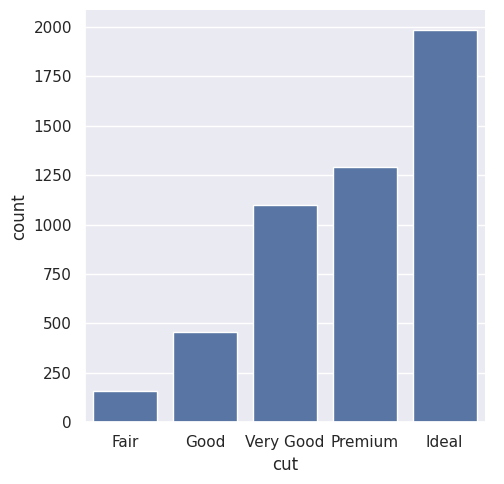

In [14]:
# Visualize the values count for the feature 'cut'
sns.catplot(x='cut', data=df, kind='count', order=cut_order);

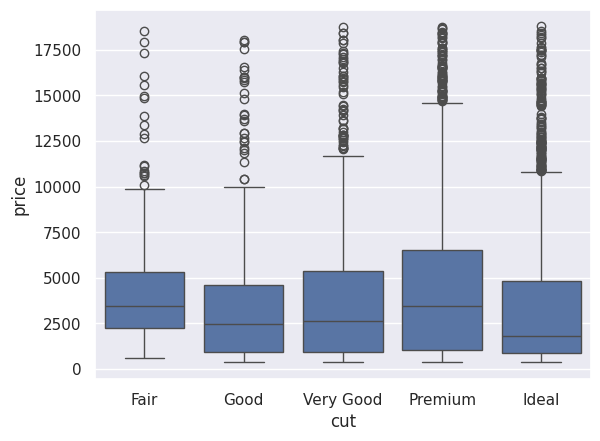

In [15]:
# Boxplot to compare each 'cut' category with price
sns.boxplot(x='cut', y='price', data=df, order=cut_order);

#### Feature 'color'

In [16]:
# From worst to best color
# (it stops at J because there are no other values in the dataset,
# but with new data it could continue to Z)
color_order = ['D', 'E', 'F', 'G', 'H', 'I', 'J']

df['color'].value_counts().reindex(color_order)

D     607
E     916
F     843
G    1095
H     762
I     517
J     248
Name: color, dtype: int64

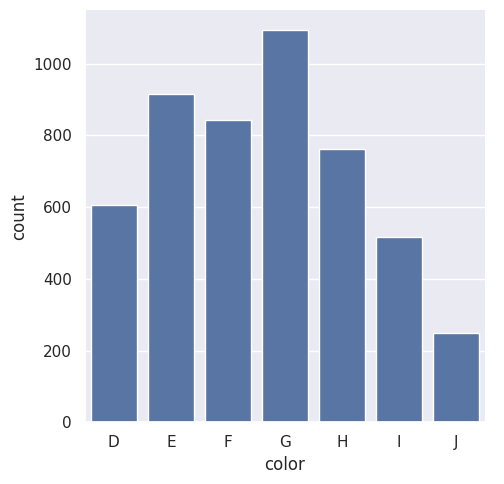

In [17]:
sns.catplot(x='color', data=df, kind='count', order=color_order);

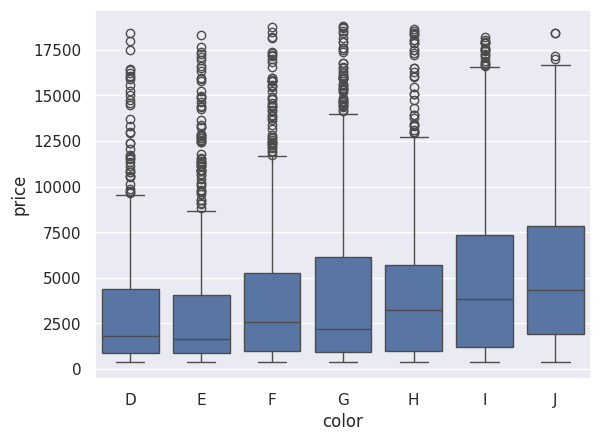

In [18]:
sns.boxplot(x='color', y='price', data=df, order=color_order);

#### Feature 'clarity'

In [19]:
# From worst to best clarity
clarity_order = ['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF']

df['clarity'].value_counts().reindex(clarity_order)

I1        64
SI2      843
SI1     1191
VS2     1130
VS1      801
VVS2     464
VVS1     345
IF       150
Name: clarity, dtype: int64

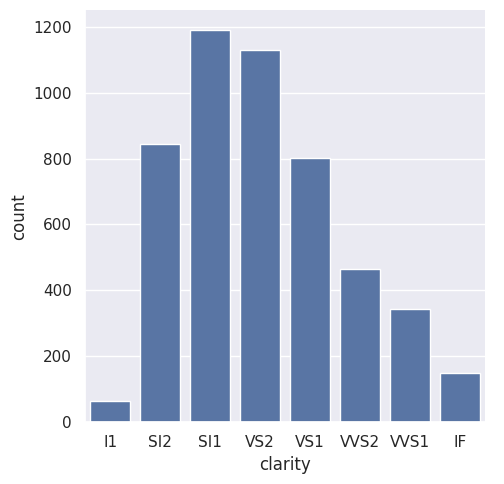

In [20]:
sns.catplot(x='clarity', data=df, kind='count', order=clarity_order);

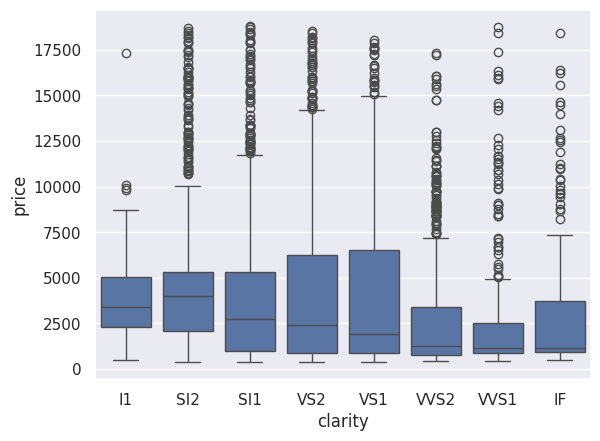

In [21]:
sns.boxplot(x='clarity', y='price', data=df, order=clarity_order);

### Numerical features and target

In [22]:
# Numerical features list, used for further operations
numerical_features = ['carat', 'depth', 'table', 'x', 'y', 'z']

# List containing the numerical features and the target, used later
numerical_features_target = numerical_features + ['price']

#### Distribution

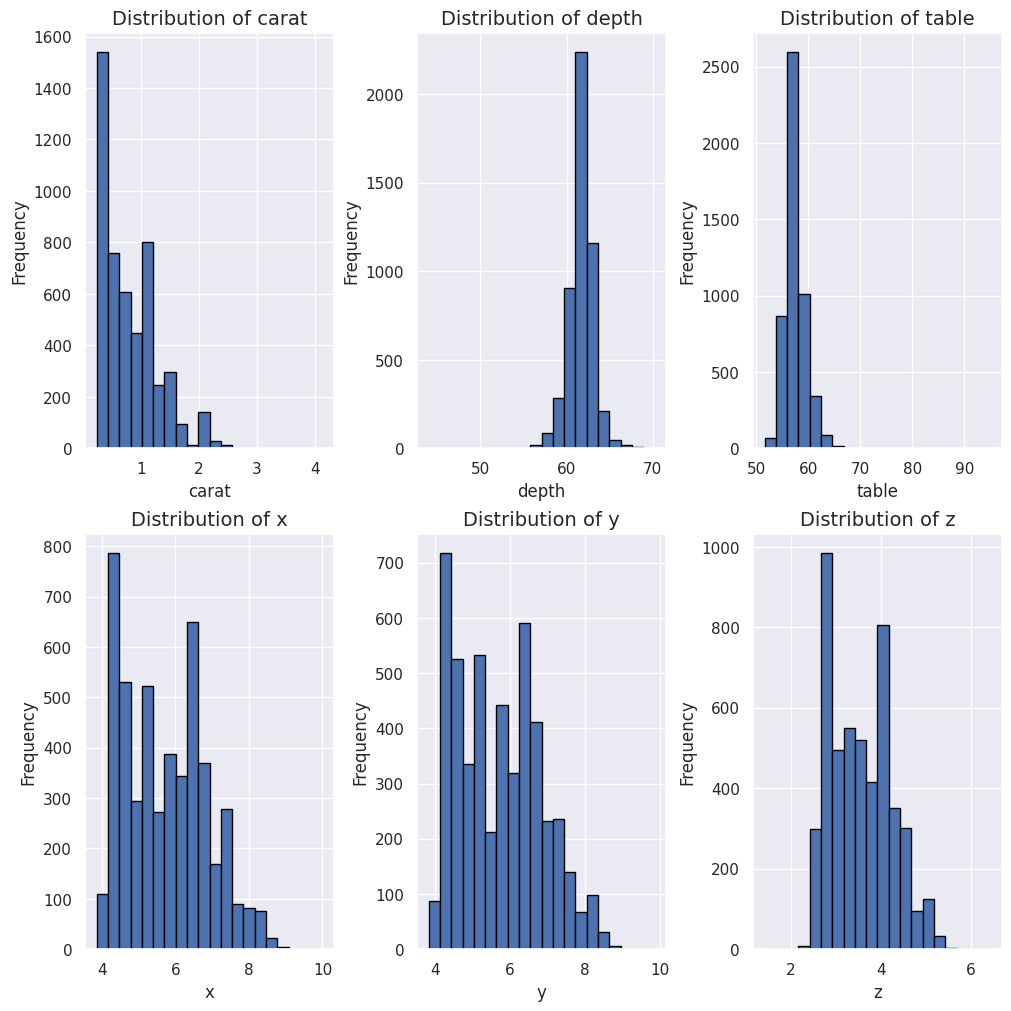

In [23]:
# Plot the distribution of each numerical feature
# using a subplot with two rows and three columns

fig, axs = plt.subplots(2, 3, figsize=(10, 10), constrained_layout=True)

for i, ax in enumerate(axs.flat):
    feature_name = numerical_features[i]

    ax.hist(df[feature_name], bins=20, edgecolor='black')

    ax.set_title('Distribution of ' + feature_name, fontsize=14)

    ax.set_xlabel(feature_name)
    ax.set_ylabel('Frequency')

plt.show()

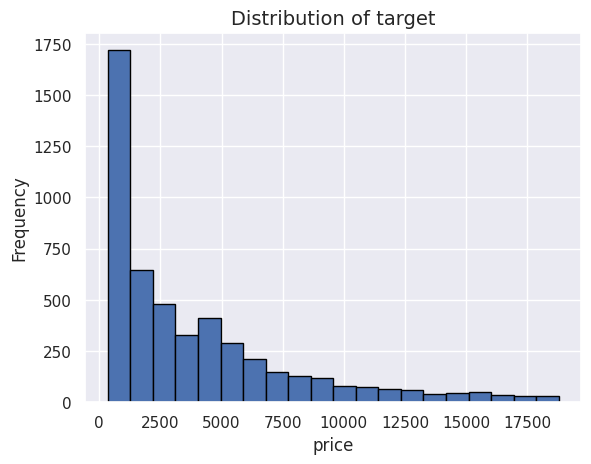

In [24]:
# Target distribution
plt.hist(df['price'], bins=20, edgecolor='black')
plt.title('Distribution of target', fontsize=14)
plt.xlabel('price')
plt.ylabel('Frequency')
plt.show()

In [25]:
# Calculate the skewness to confirm the plot
df[numerical_features_target].skew()

carat    1.075924
depth   -0.449441
table    1.479177
x        0.377488
y        0.368847
z        0.375619
price    1.587217
dtype: float64

In [26]:
# Calculate the kurtosis to confirm the plot
df[numerical_features_target].kurtosis()

carat     1.156953
depth     7.112062
table    15.526110
x        -0.748175
y        -0.767058
z        -0.710816
price     2.078182
dtype: float64

#### Correlation between each numerical feature and the target price

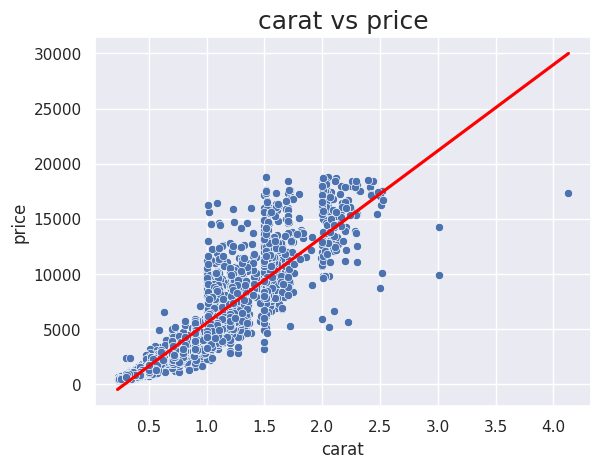

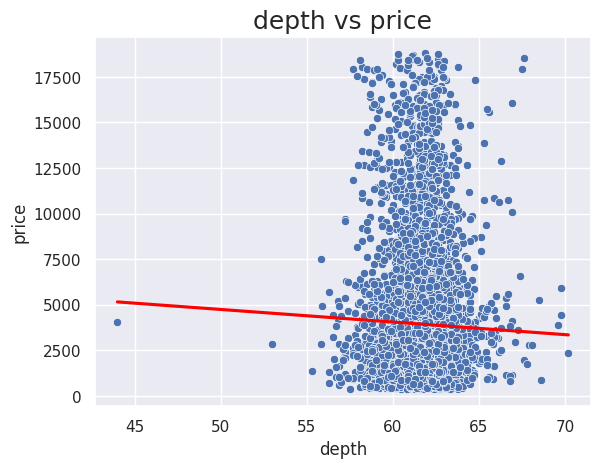

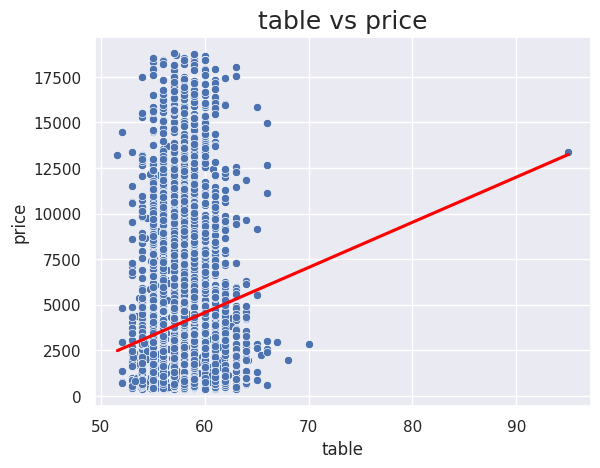

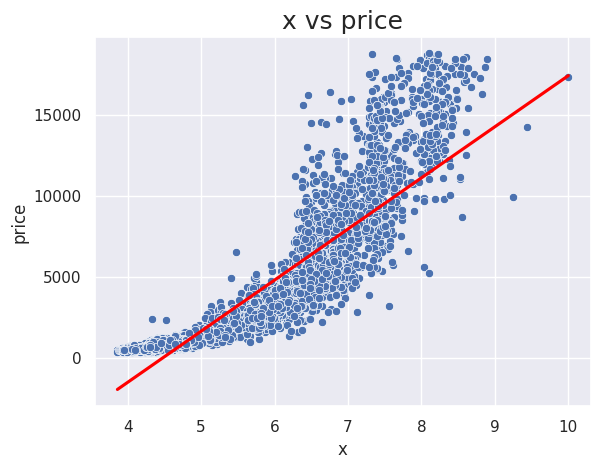

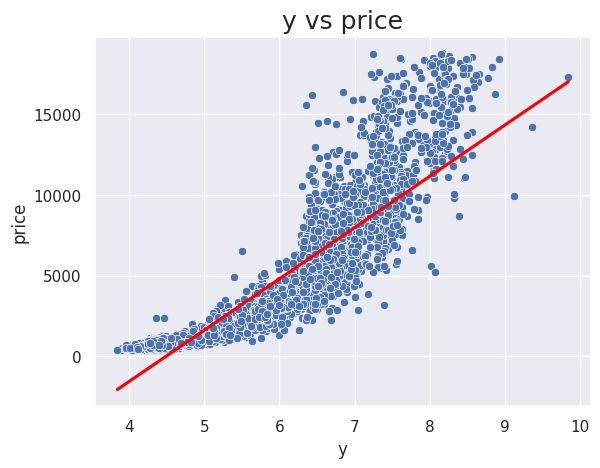

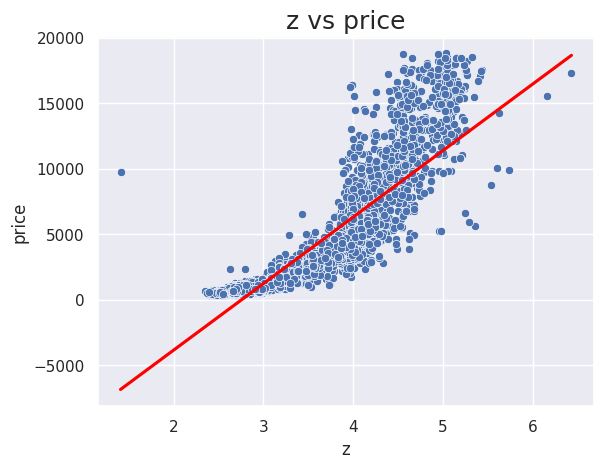

In [27]:
# Check for correlation using a scatterplot and the regression line
for feature in numerical_features:
  sns.scatterplot(x=feature, y='price', data=df)
  sns.regplot(x=feature, y='price', data=df, color='red', scatter=False, ci=None)
  plt.title(feature + ' vs price', fontsize=18)
  plt.show()

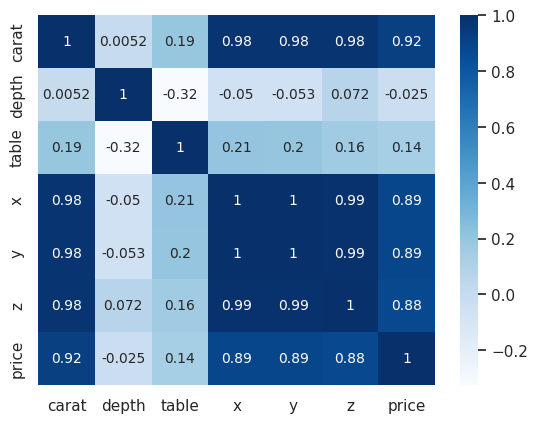

In [28]:
# Confirm the correlations with the correlation matrix
corr_matrix = df[numerical_features_target].corr()

sns.heatmap(corr_matrix, annot = True, cmap = 'Blues', annot_kws={"size": 10});

## Features encoding

In [29]:
# To encode the categorical features cut, color, clarity
# we can exploit ordinal encoding (since the values have an order)
# and the lists cut_order, color_order and clarity_order

# Cut encoding
encoded_cut = OrdinalEncoder(
    categories=[cut_order]
).fit_transform(df[['cut']])

# Color encoding
encoded_color = OrdinalEncoder(
    categories=[color_order]
).fit_transform(df[['color']])

# Clarity encoding
encoded_clarity = OrdinalEncoder(
    categories=[clarity_order]
).fit_transform(df[['clarity']])

In [30]:
# Save the encoding in the dataframe, overwriting the categorical values
df['cut'] = encoded_cut
df['color'] = encoded_color
df['clarity'] = encoded_clarity

In [31]:
# Cast the columns correctly
df['cut'] = df['cut'].astype('category')
df['color'] = df['color'].astype('category')
df['clarity'] = df['clarity'].astype('category')

In [32]:
# New types to confirm
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4988 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   carat    4988 non-null   float64 
 1   cut      4988 non-null   category
 2   color    4988 non-null   category
 3   clarity  4988 non-null   category
 4   depth    4988 non-null   float64 
 5   table    4988 non-null   float64 
 6   price    4988 non-null   int64   
 7   x        4988 non-null   float64 
 8   y        4988 non-null   float64 
 9   z        4988 non-null   float64 
dtypes: category(3), float64(6), int64(1)
memory usage: 327.3 KB


In [33]:
# New cut values
# 'Fair' => 0
# 'Good' => 1
# 'Very Good' => 2
# 'Premium' => 3
# 'Ideal' => 4
df['cut'].value_counts().sort_index(ascending=True)

0.0     158
1.0     456
2.0    1097
3.0    1290
4.0    1987
Name: cut, dtype: int64

In [34]:
# New color values
# 'D' => 0
# 'E' => 1
# 'F' => 2
# 'G' => 3
# 'H' => 4
# 'I' => 5
# 'J' => 6
df['color'].value_counts().sort_index(ascending=True)

0.0     607
1.0     916
2.0     843
3.0    1095
4.0     762
5.0     517
6.0     248
Name: color, dtype: int64

In [35]:
# New clarity values
# 'I1' => 0
# 'SI2' => 1
# 'SI1' => 2
# 'VS2' => 3
# 'VS1' => 4
# 'VVS2' => 5
# 'VVS1' => 6
# 'IF' => 7
df['clarity'].value_counts().sort_index(ascending=True)

0.0      64
1.0     843
2.0    1191
3.0    1130
4.0     801
5.0     464
6.0     345
7.0     150
Name: clarity, dtype: int64

# Model development and evaluation

We use H2O AutoML for obtaining a good regression model without a lot of effort and also to achieve model explainability, since in the challenge it is required to know the why behind every price.

We will prefer clarity over the performance metrics, since the task is not about building the fanciest model.

## Initialize H2O and split data

In [36]:
# Initialize H2O
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.22" 2024-01-16; OpenJDK Runtime Environment (build 11.0.22+7-post-Ubuntu-0ubuntu222.04.1); OpenJDK 64-Bit Server VM (build 11.0.22+7-post-Ubuntu-0ubuntu222.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpibsc_ukv
  JVM stdout: /tmp/tmpibsc_ukv/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpibsc_ukv/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,04 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.1
H2O_cluster_version_age:,20 days
H2O_cluster_name:,H2O_from_python_unknownUser_vply5x
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.170 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [37]:
# Target column name
y = 'price'

# Features list
X = list(df.columns)
X.remove(y)

# Convert from Pandas DataFrame to H2OFrame for compatibility
h2o_df = h2o.H2OFrame(df)

# Split into train and test (80% - 20%)
# Validation is not needed thanks to the library auto-tuning
train, test = h2o_df.split_frame(ratios = [.8], seed=1234)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


## Obtain the regression model

In [38]:
# We only consider single models to achieve a clearer explainability
aml = H2OAutoML(max_models=10, seed=1234, exclude_algos=['StackedEnsemble'])

# Train H2O
aml.train(
    x=X,
    y=y,
    training_frame=train
)

# Retrieve the best model
model = aml.leader

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


In [39]:
# Model details: Gradient Boosting Machine was chosen as the best model
model

Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_3_AutoML_1_20240402_235245


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    60                 60                          69545                  8            8            8             14            146           87.5

ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 151499.30417757816
RMSE: 389.22911527476737
MAE: 208.74937460692323
RMSLE: 0.07742859636492182
Mean Residual Deviance: 151499.30417757816

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 451434.3874906711
RMSE: 671.888671946976
MAE: 327.92018928276855
RMSLE: 0.11148310241799429
Mean Residual Deviance: 451434.3874906711

Cross-Validation Metrics Summary: 
                        mean      sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  --------  ----------  ------------  ------------  ------------  ------------  ------------
aic                     nan       0           nan           nan           nan           nan           nan
loglikelihood           nan       0           nan           nan           nan           nan           nan
mae                     327.174   27.7149     307.55        319.23        347.268       364.021       297.8
mean_residual_deviance  454982    69010.4     410488        426211        500430        551926        385854
mse                     454982    69010.4     410488        426211        500430        551926        385854
r2                      0.971197  0.00231202  0.968043      0.972143      0.971705      0.969945      0.974148
residual_deviance       454982    69010.4     410488        426211        500430        551926        385854
rmse                    673.008   50.5185     640.694       652.848       707.411       742.917       621.172
rmsle                   0.110891  0.00383687  0.106645      0.112413      0.115315      0.107081      0.113001

Scoring History: 
    timestamp            duration    number_of_trees    training_rmse    training_mae    training_deviance
--  -------------------  ----------  -----------------  ---------------  --------------  -------------------
    2024-04-02 23:53:43  4.513 sec   0                  3981.6           3049.62         1.58531e+07
    2024-04-02 23:53:43  4.610 sec   5                  2443.16          1829.73         5.96901e+06
    2024-04-02 23:53:43  4.711 sec   10                 1534.22          1118.87         2.35383e+06
    2024-04-02 23:53:43  4.815 sec   15                 1020.15          714.361         1.0407e+06
    2024-04-02 23:53:43  4.915 sec   20                 742.134          489.072         550763
    2024-04-02 23:53:44  5.026 sec   25                 594.212          365.036         353088
    2024-04-02 23:53:44  5.118 sec   30                 513.189          293.269         263363
    2024-04-02 23:53:44  5.205 sec   35                 466.464          254.722         217589
    2024-04-02 23:53:44  5.315 sec   40                 438.767          233.933         192517
    2024-04-02 23:53:44  5.398 sec   45                 421.431          223.113         177604
    2024-04-02 23:53:44  5.482 sec   50                 407.246          215.806         165849
    2024-04-02 23:53:44  5.554 sec   55                 396.993          211.542         157603
    2024-04-02 23:53:44  5.617 sec   60                 389.229          208.749         151499

Variable Importances: 
variable    relative_importance    scaled_importance    percentage
----------  ---------------------  -------------------  ------------
carat       1.3551e+11             1                    0.441376
y           1.1

## Predictions and performance evaluation

In [40]:
# If we want to calculate precise metrics on the test set,
# we must keep in mind that the predictions return float values and not integers

# Let's see what the metrics would be if we consider float predictions
model.model_performance(test)

ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 409882.1657458409
RMSE: 640.2204040374228
MAE: 324.66595348361824
RMSLE: 0.1091833210955337
Mean Residual Deviance: 409882.1657458409

In [41]:
# Now let's manually get the predictions
predictions = model.predict(test)
predictions

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


predict
11746.1
530.022
3715.45
8421.5
12493.8
2393.38
592.917
16950.1
481.897
1108.03


In [42]:
# ... and round them to obtain integer predictions
predictions = predictions.round()
predictions

predict
11746
530
3715
8421
12494
2393
593
16950
482
1108


In [43]:
# To calculate the metrics, we need to perform a conversion first

# To ignore the conversion warning that suggests to install a library
# to use multi-threading
import warnings
warnings.filterwarnings('ignore')

# Convert from H2OFrame column to Pandas Series for compatibility
actual_prices = test[y].as_data_frame()['price']
predicted_prices = predictions.as_data_frame()['predict']

In [44]:
# Finally, we can calculate MSE, RMSE, MAE, RMSLE, Mean Residual Deviance
# and, why not, R^2 too

# Calculate the metrics on the test set
mse = mean_squared_error(actual_prices, predicted_prices)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual_prices, predicted_prices)
rmsle = np.sqrt(mean_squared_log_error(actual_prices, predicted_prices))
mean_residual_deviance = mse

# Let's also calculate R^2
r2 = r2_score(actual_prices, predicted_prices)

In [45]:
# Here are the precise metrics (and R^2), which present small differences
print("** Manual report on test data using rounded predictions. **")
print("MSE:", mse)
print("RMSE:", rmse)
print("MAE:", mae)
print("RMSLE:", rmsle)
print("Mean Residual Deviance:", mean_residual_deviance)
print("R^2:", r2)

** Manual report on test data using rounded predictions. **
MSE: 409873.2
RMSE: 640.213401921578
MAE: 324.6619289340102
RMSLE: 0.10918131961762595
Mean Residual Deviance: 409873.2
R^2: 0.9733988787440877


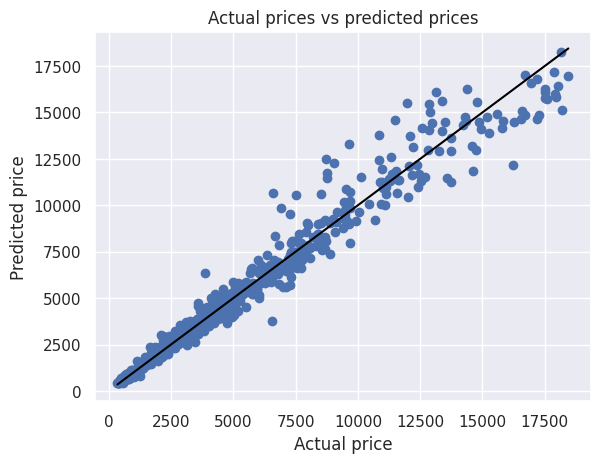

In [46]:
# Plot actual prices vs predicted prices, if on the diagonal it's perfect
plt.scatter(actual_prices, predicted_prices)
plt.xlabel('Actual price')
plt.ylabel('Predicted price')
plt.title('Actual prices vs predicted prices')
plt.plot([min(actual_prices), max(actual_prices)], [min(actual_prices), max(actual_prices)], color='black')
plt.show()

## Model explainability

# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id,rmse,mse,mae,rmsle,mean_residual_deviance,training_time_ms,predict_time_per_row_ms,algo
GBM_2_AutoML_1_20240402_235245,625.431,391164,315.619,0.109054,391164,684,0.02619,GBM
XGBoost_3_AutoML_1_20240402_235245,632.941,400615,341.811,0.122248,400615,615,0.010171,XGBoost
GBM_3_AutoML_1_20240402_235245,640.22,409882,324.666,0.109183,409882,1117,0.031513,GBM
GBM_4_AutoML_1_20240402_235245,643.129,413615,319.606,0.106164,413615,671,0.035125,GBM
XGBoost_1_AutoML_1_20240402_235245,691.858,478667,365.123,0.116568,478667,922,0.008489,XGBoost
XGBoost_2_AutoML_1_20240402_235245,697.709,486798,362.822,0.119074,486798,644,0.007028,XGBoost
GBM_1_AutoML_1_20240402_235245,719.67,517925,360.547,0.145926,517925,2474,0.061501,GBM
DRF_1_AutoML_1_20240402_235245,757.915,574436,378.872,0.124527,574436,1745,0.042706,DRF
XRT_1_AutoML_1_20240402_235245,822.072,675803,402.332,0.131646,675803,2616,0.04426,DRF
GLM_1_AutoML_1_20240402_235245,3925.97,1.54132e+07,3017.82,1.13987,1.54132e+07,39,0.011417,GLM


# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

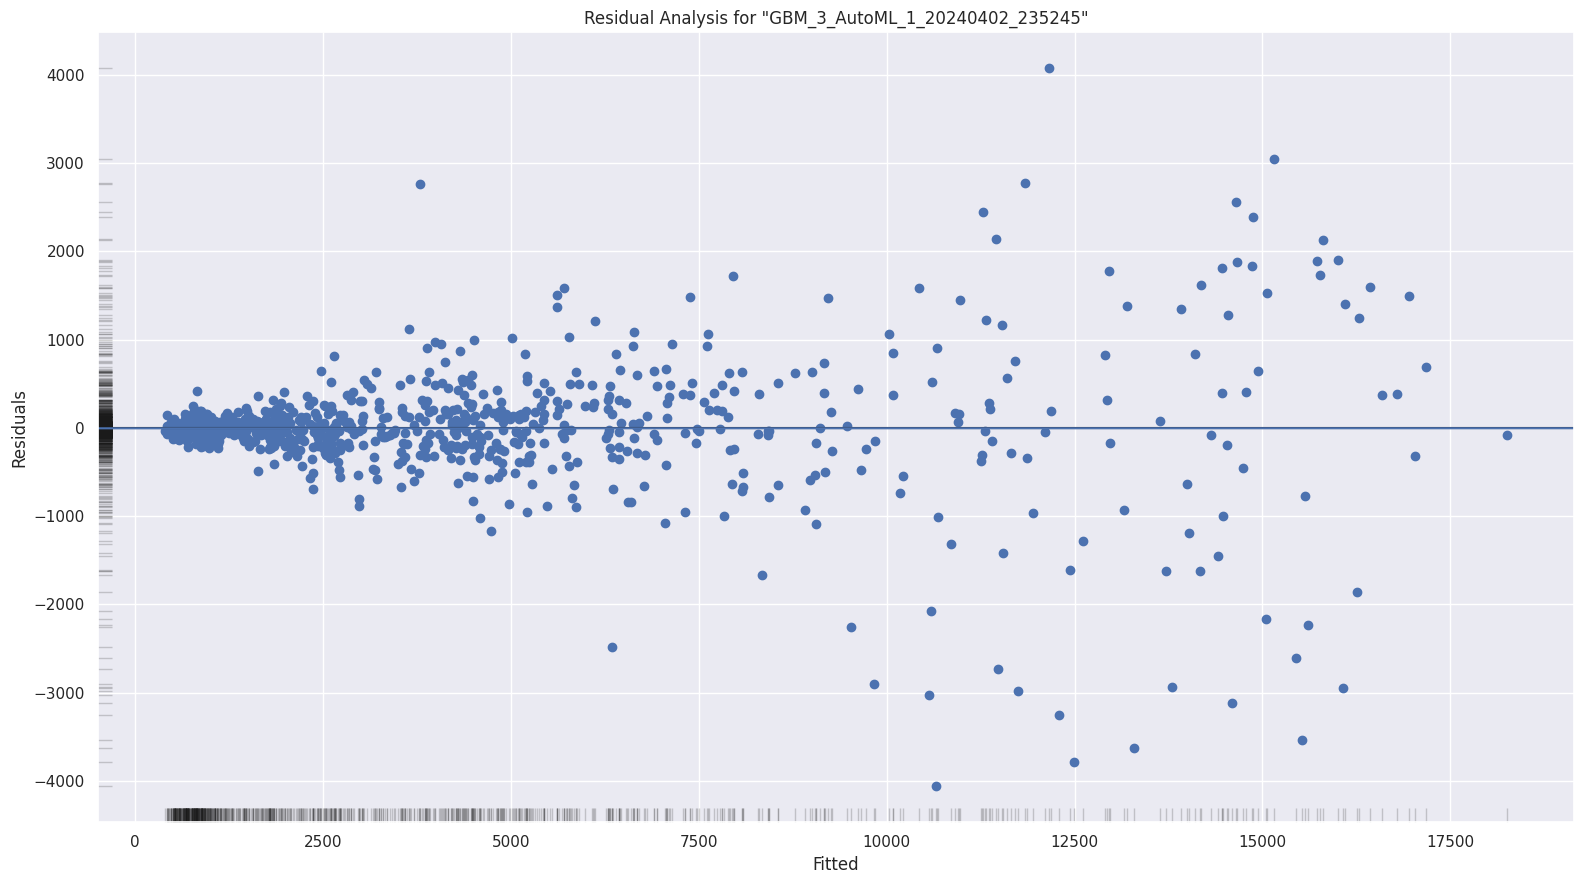

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

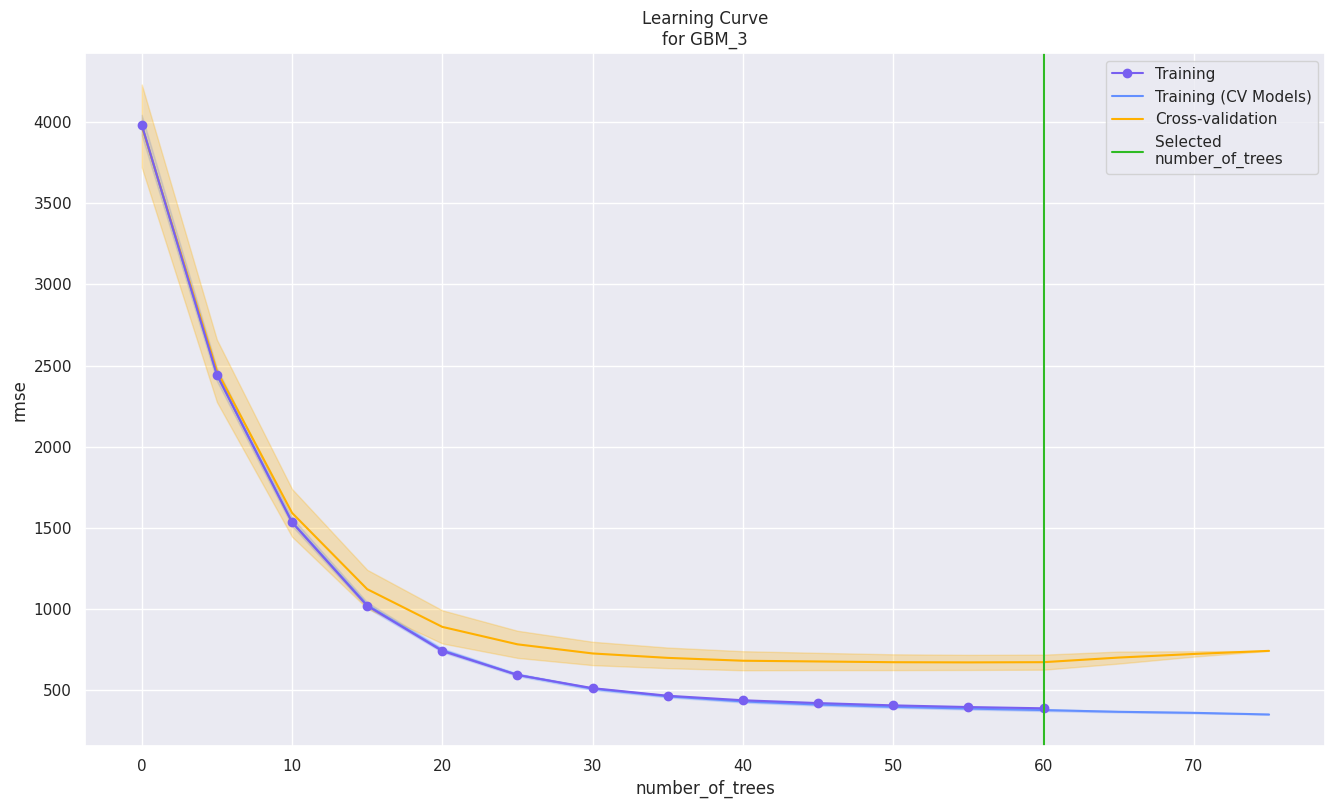

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

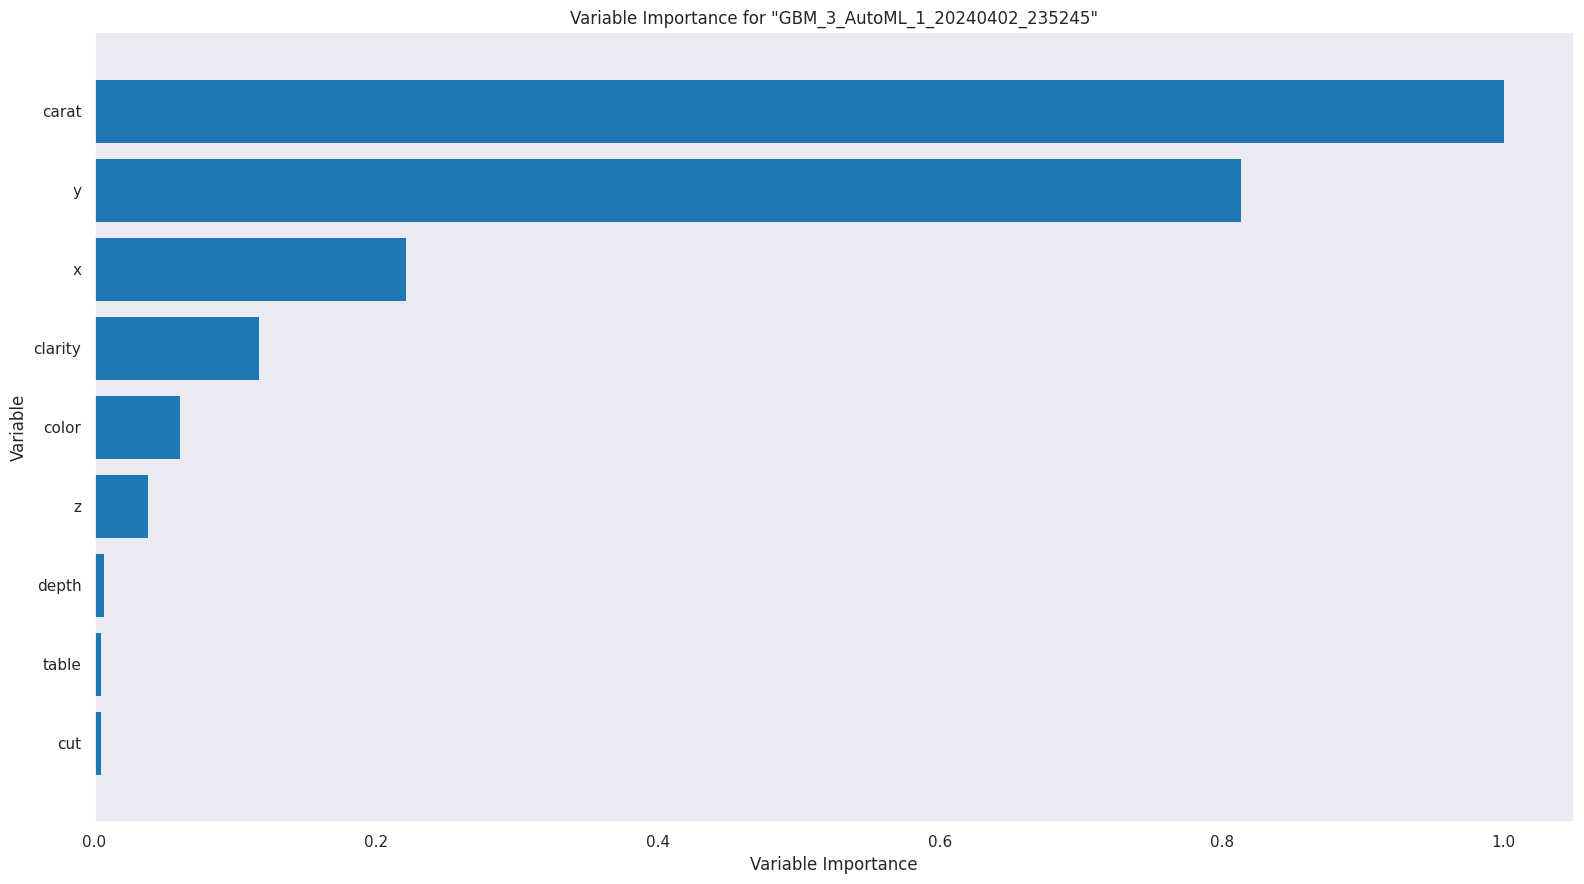

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

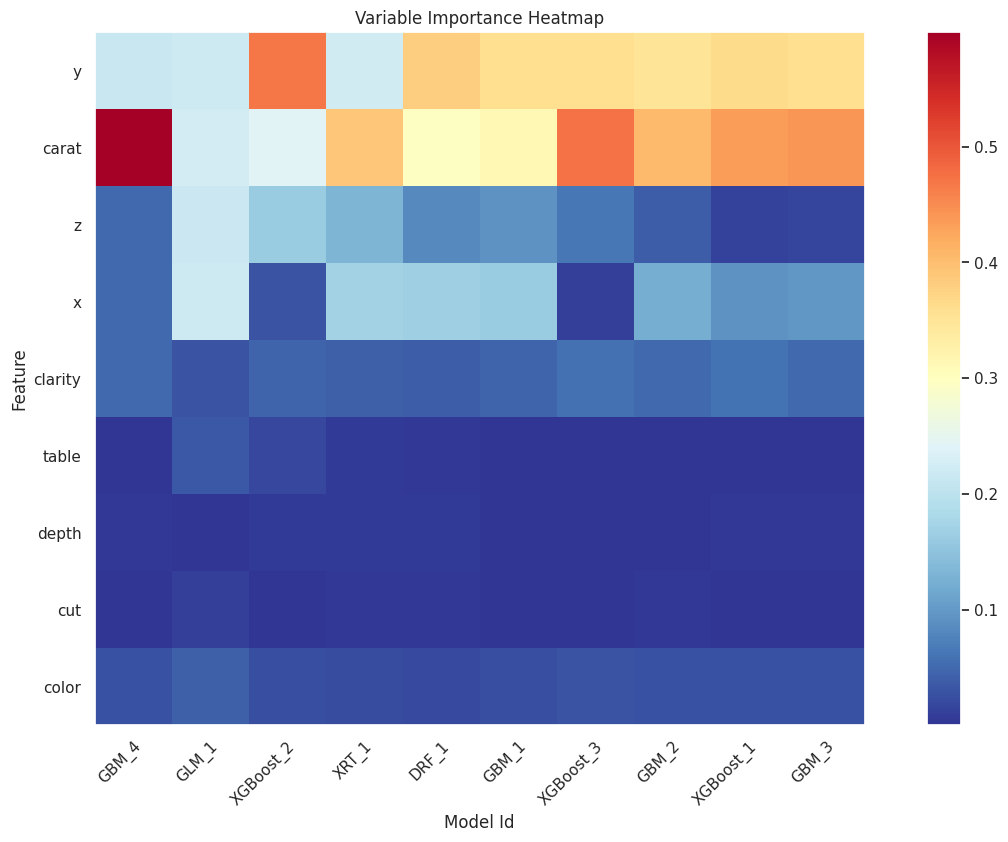

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

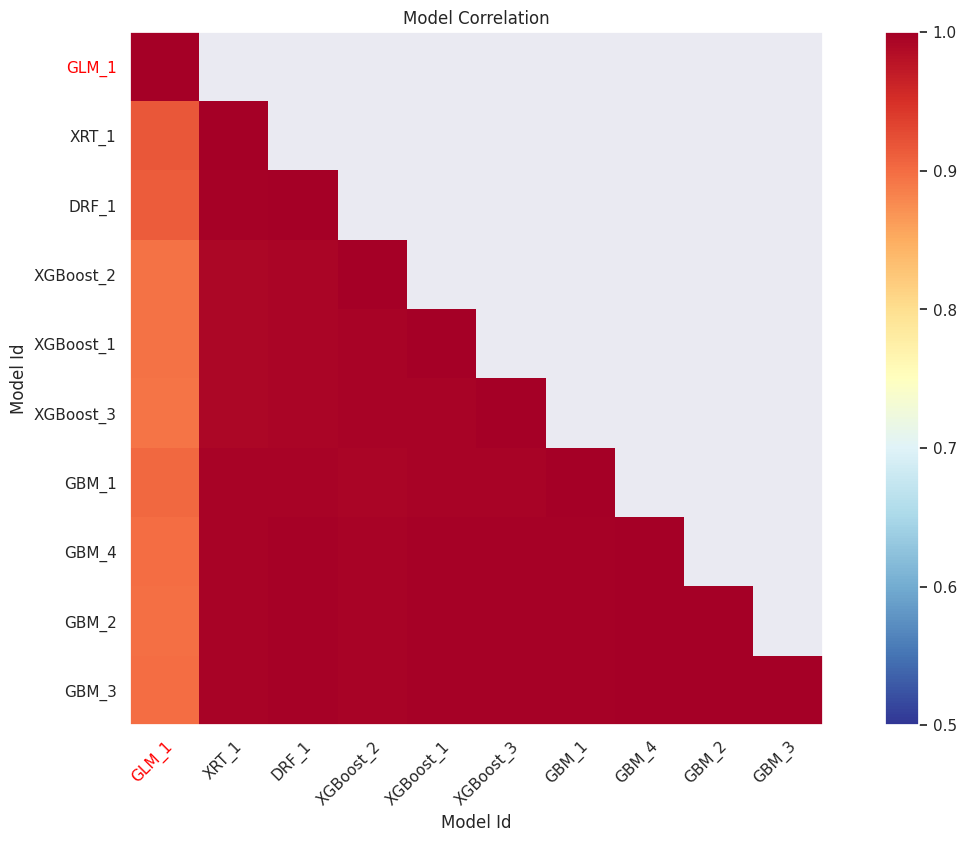

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

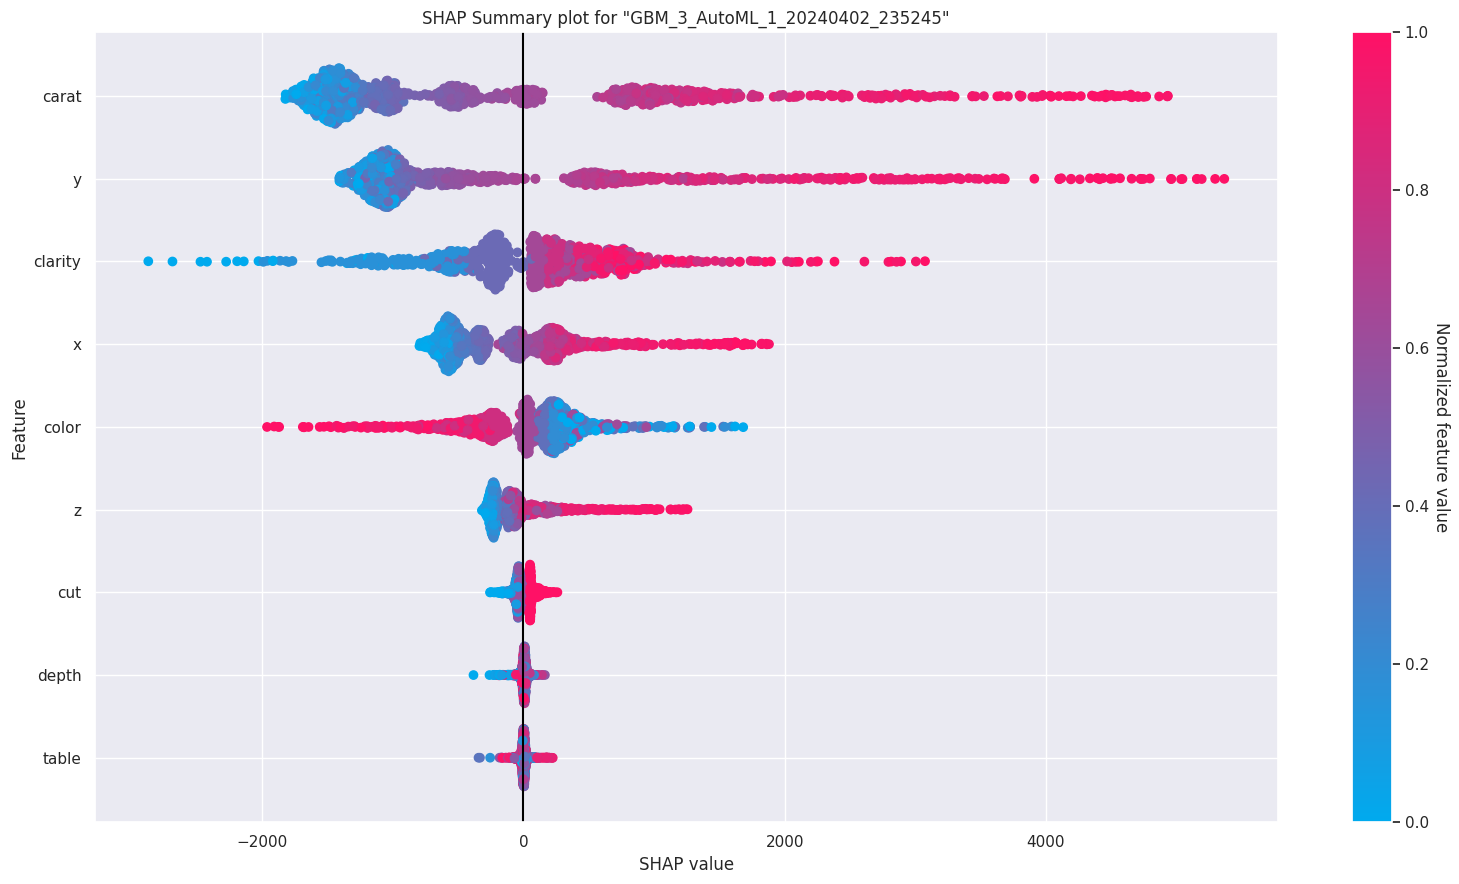

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

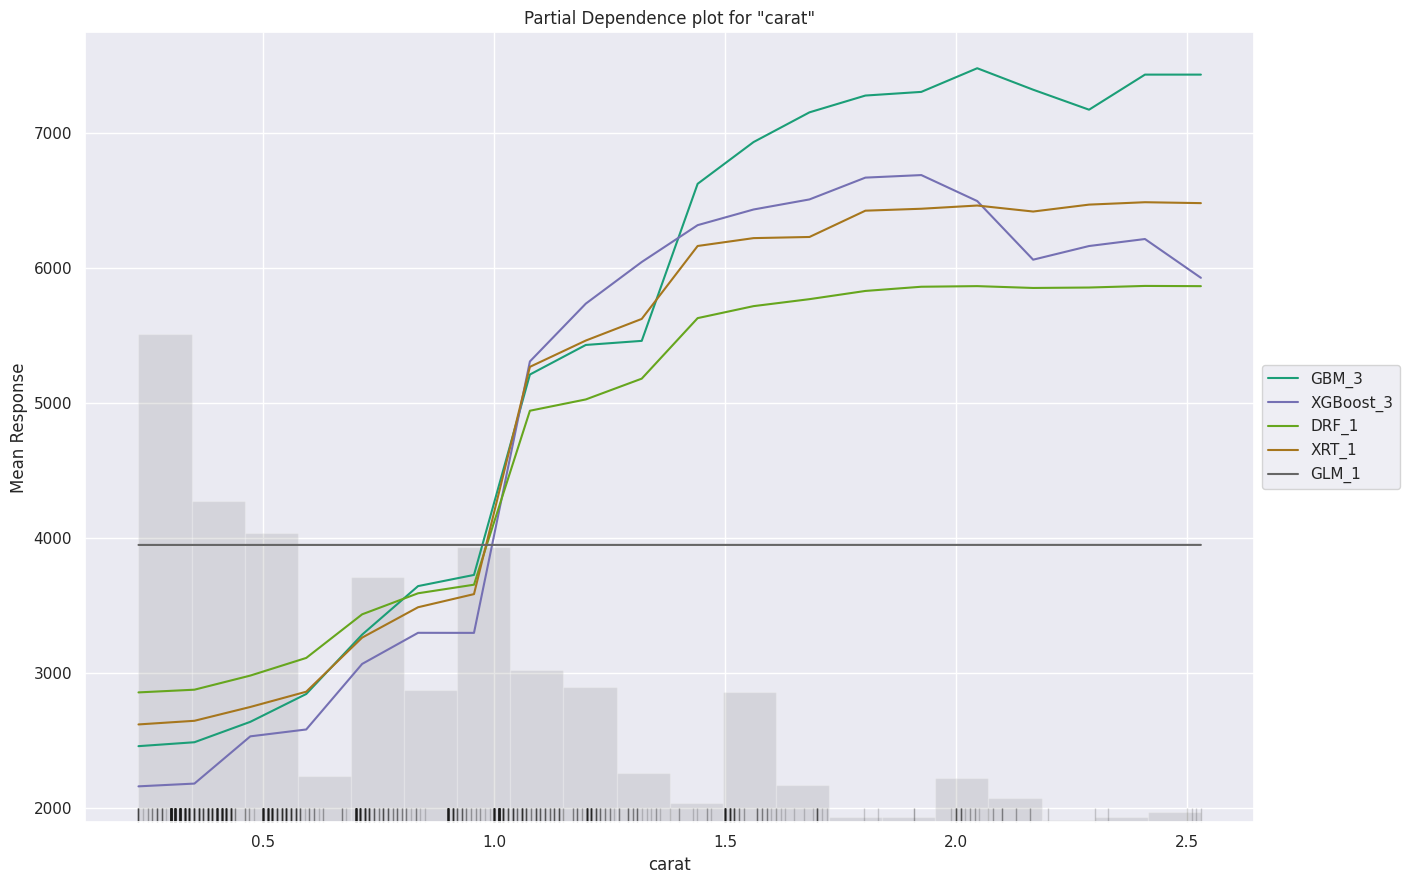

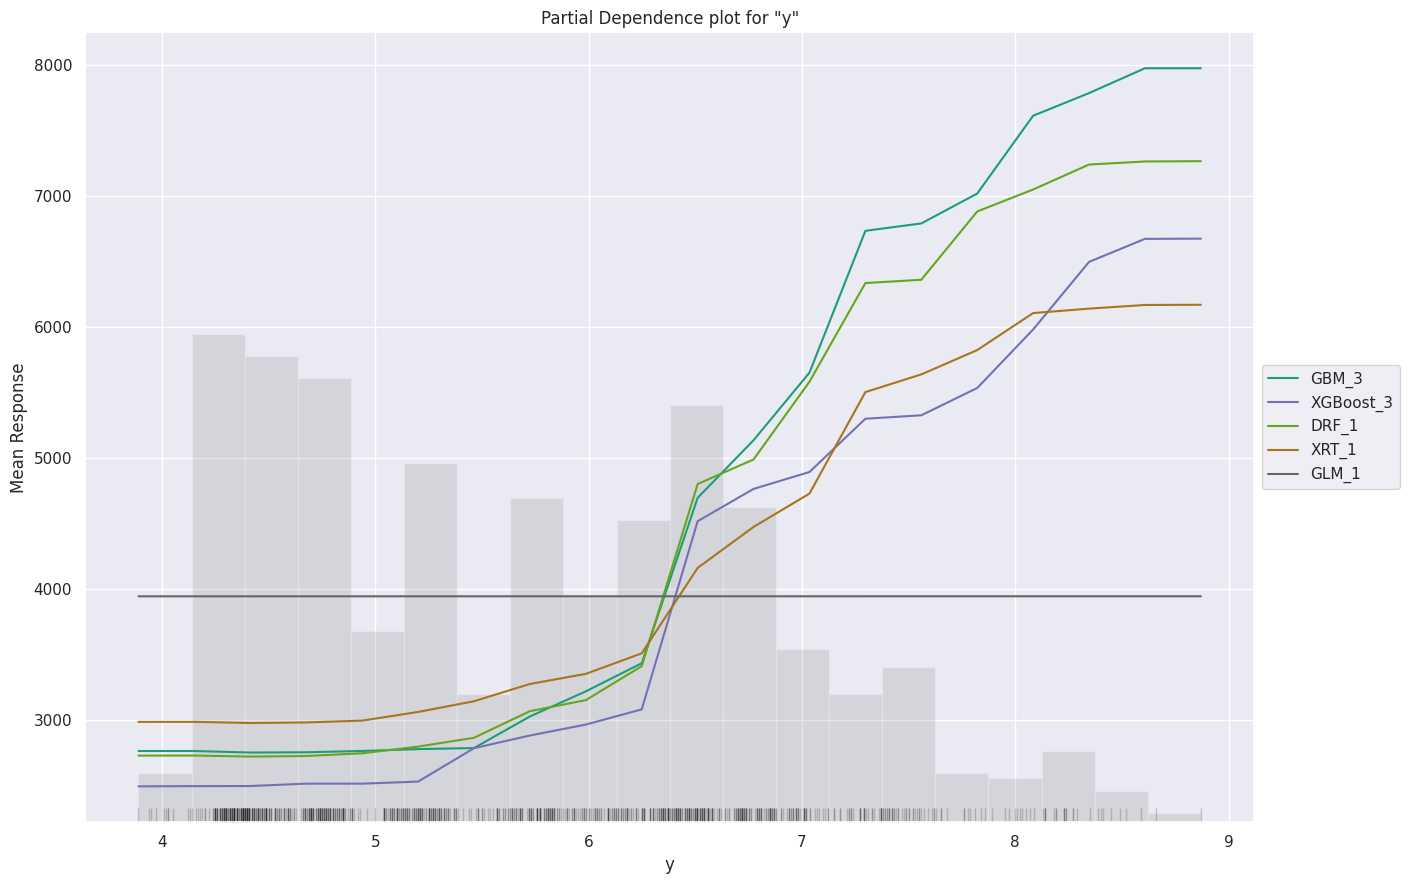

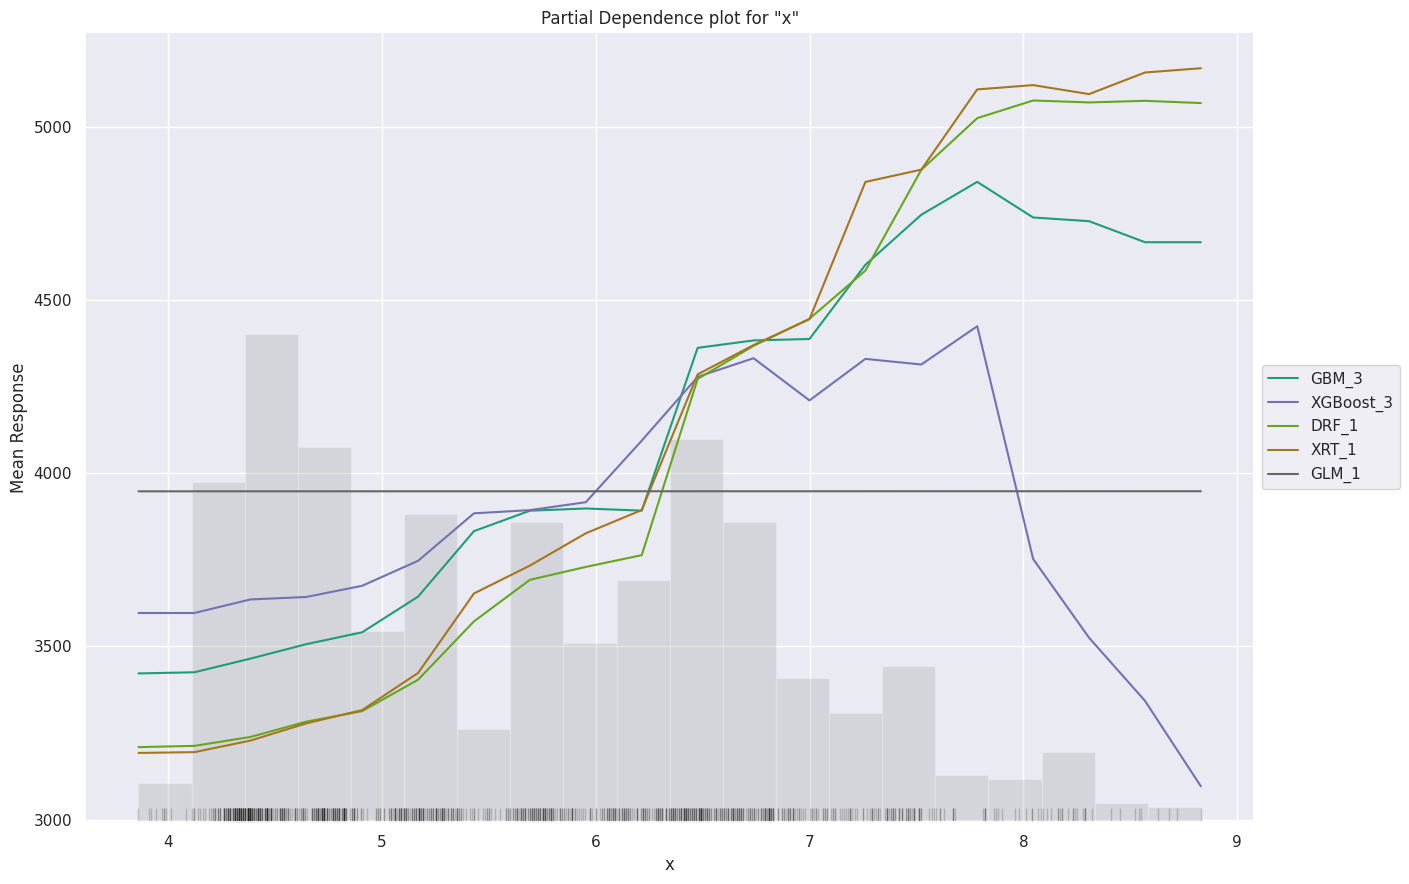

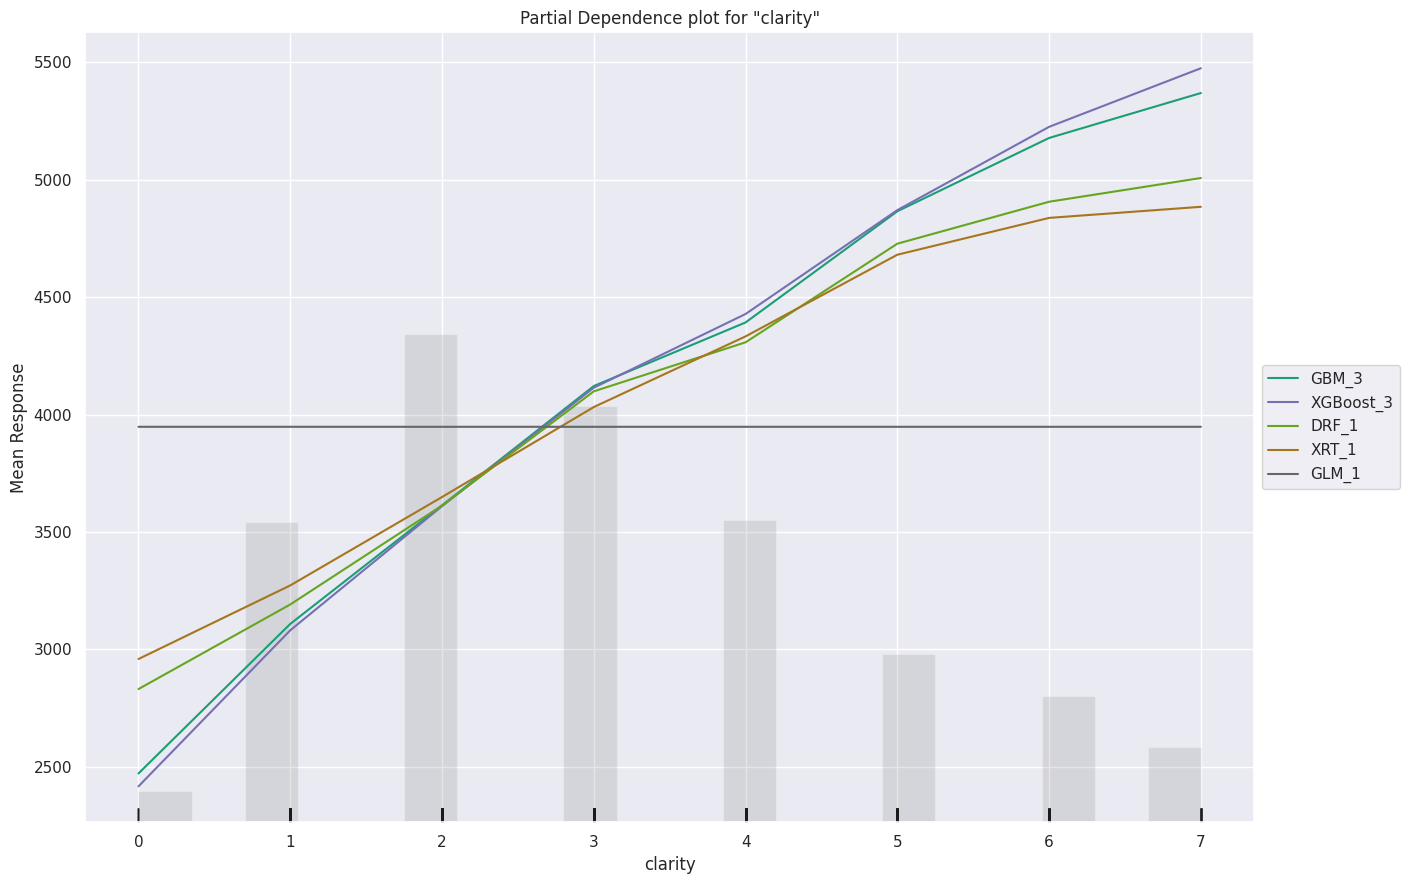

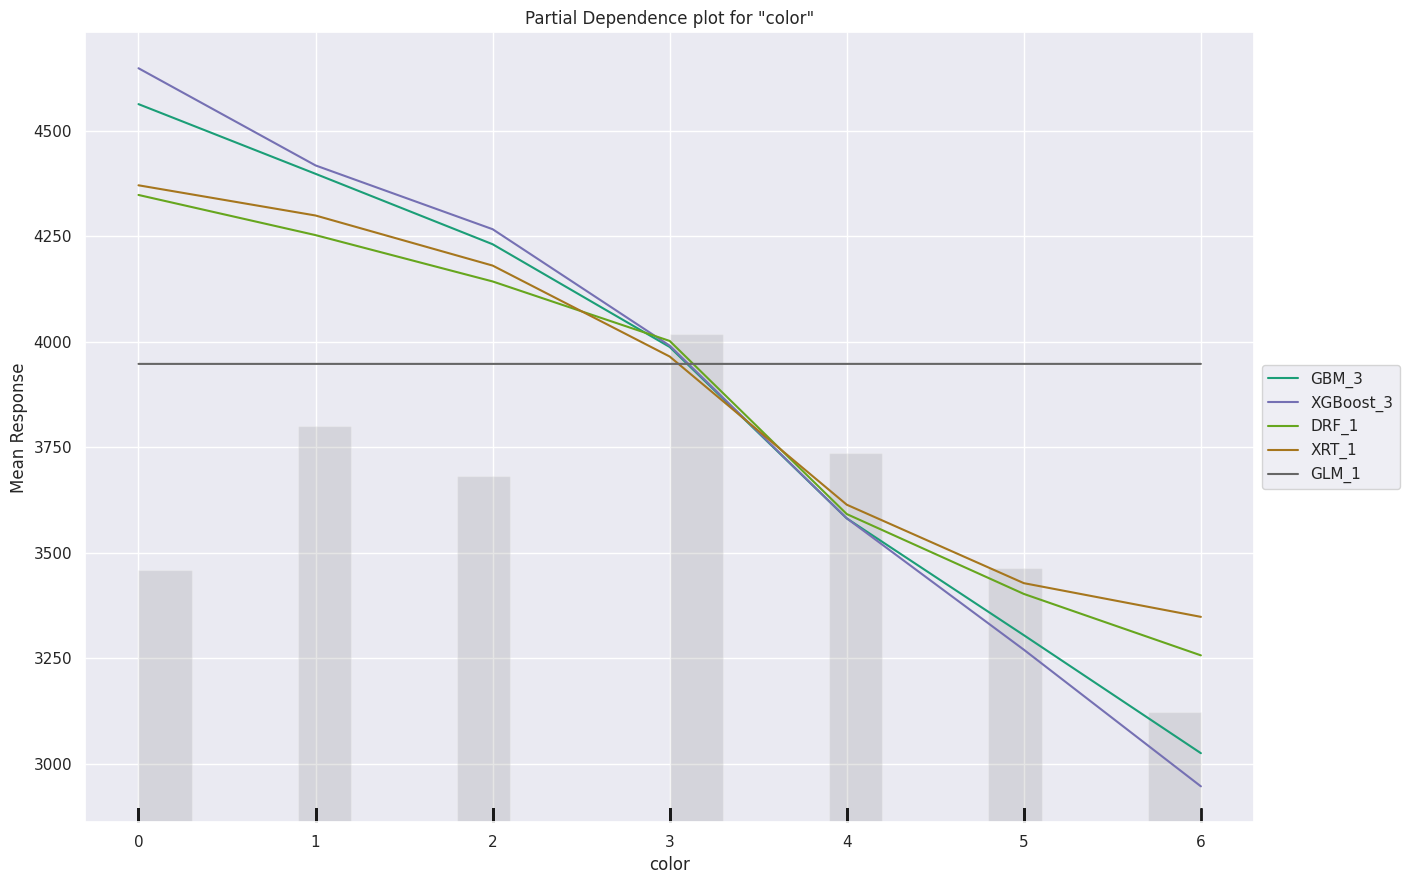

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

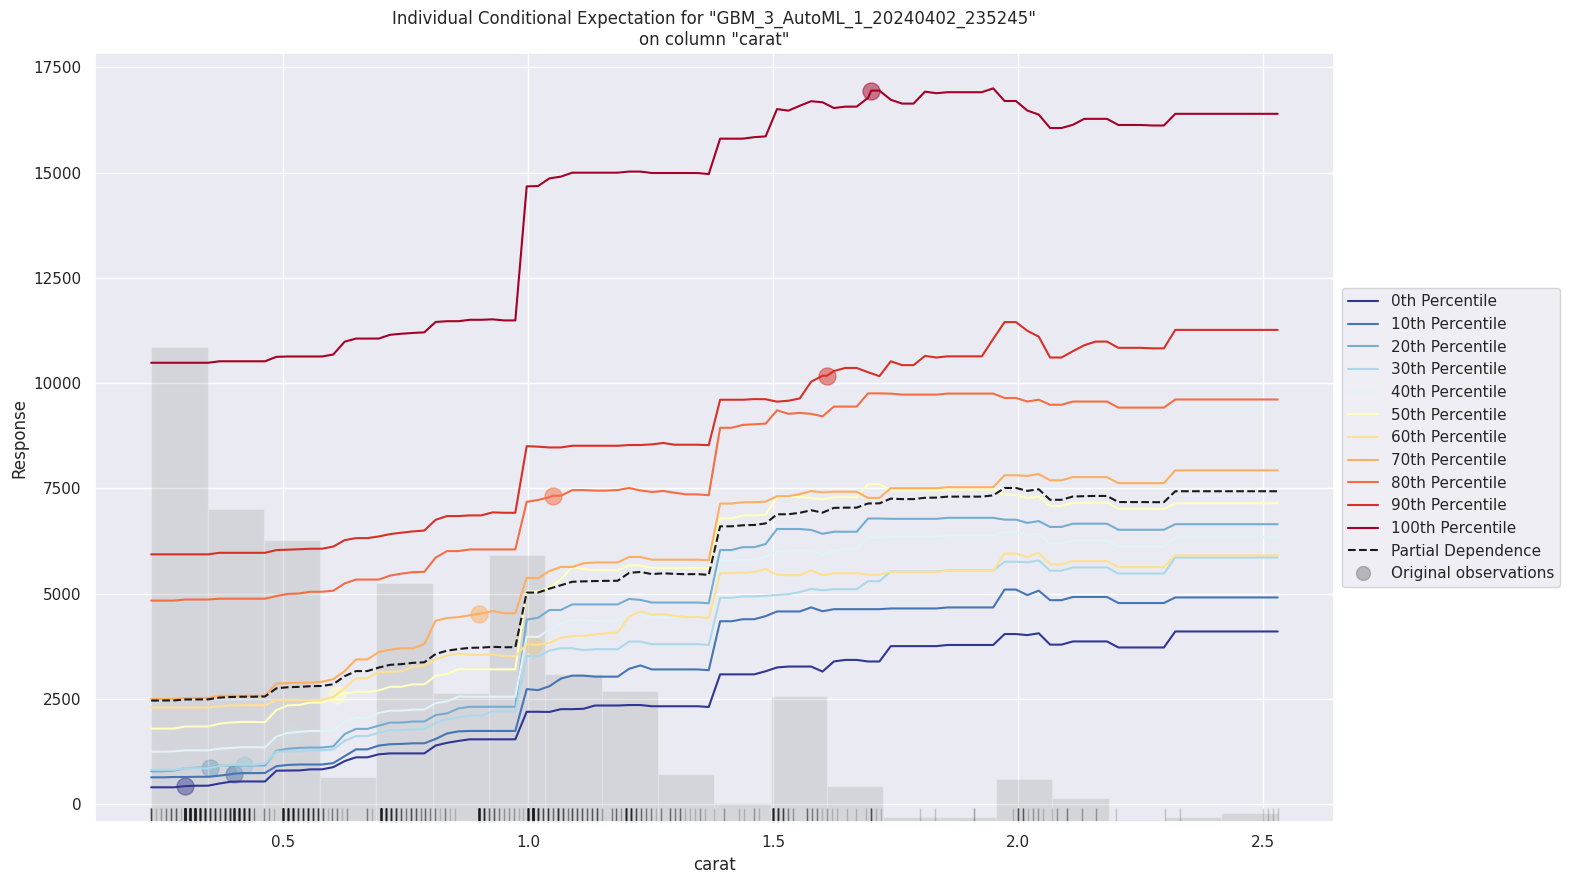

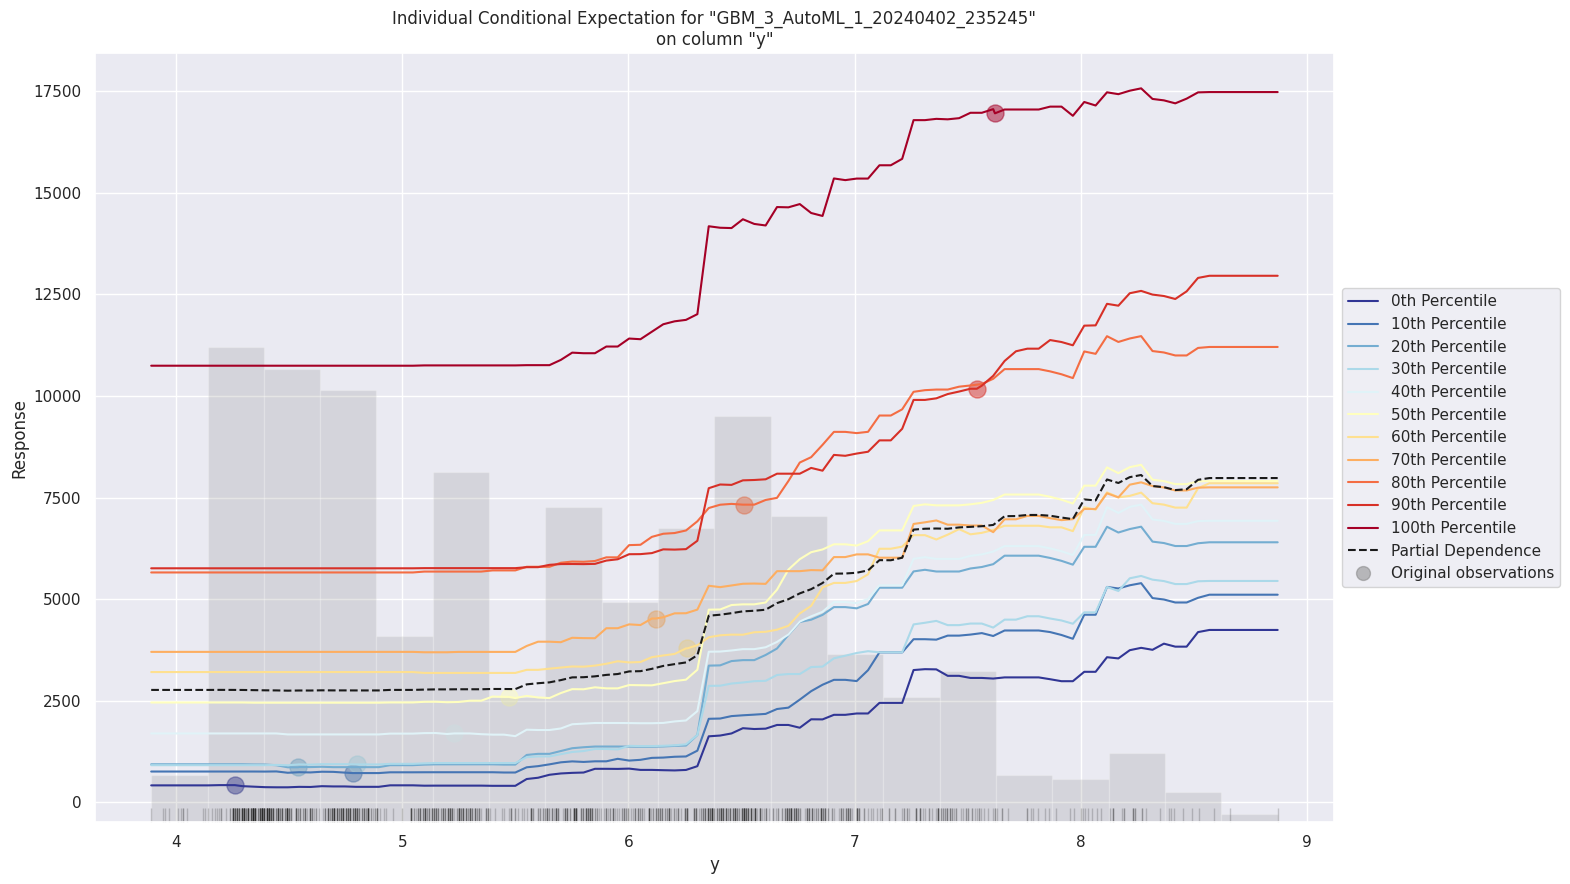

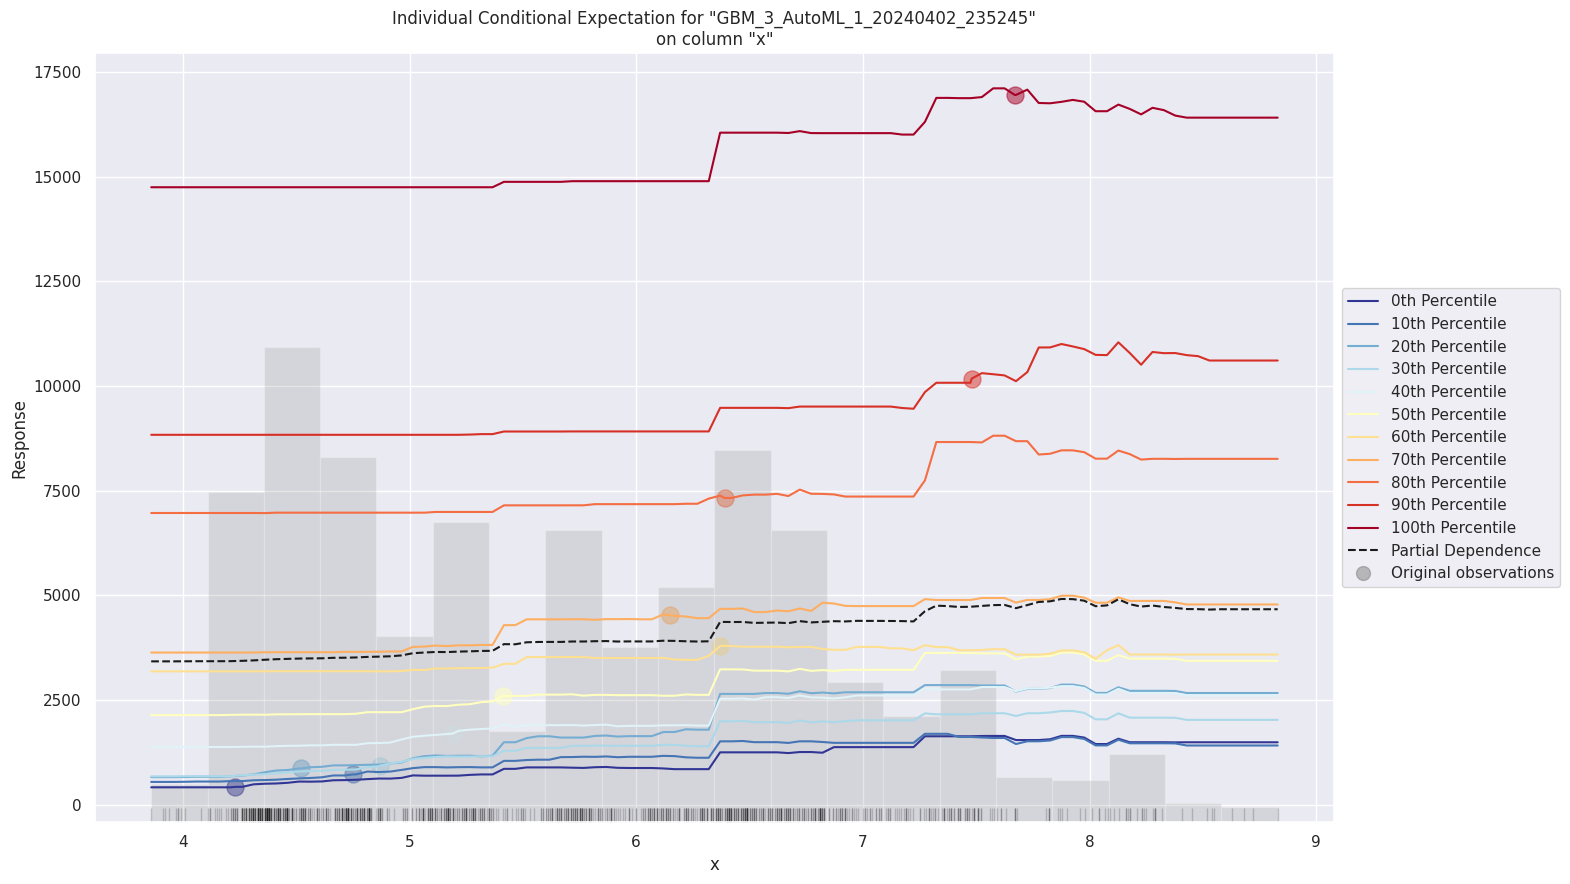

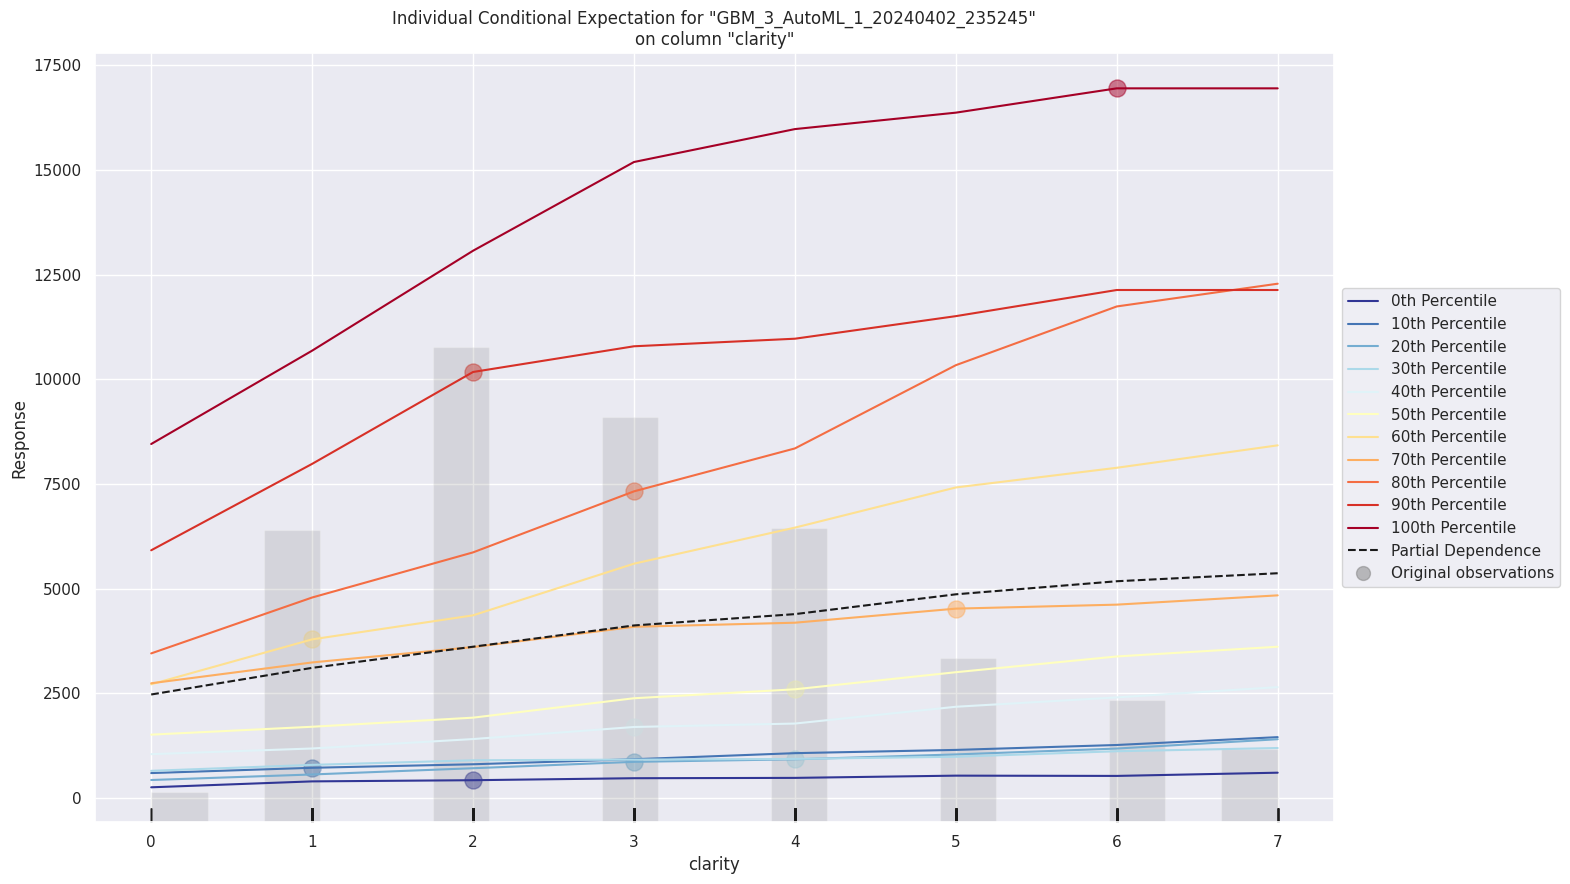

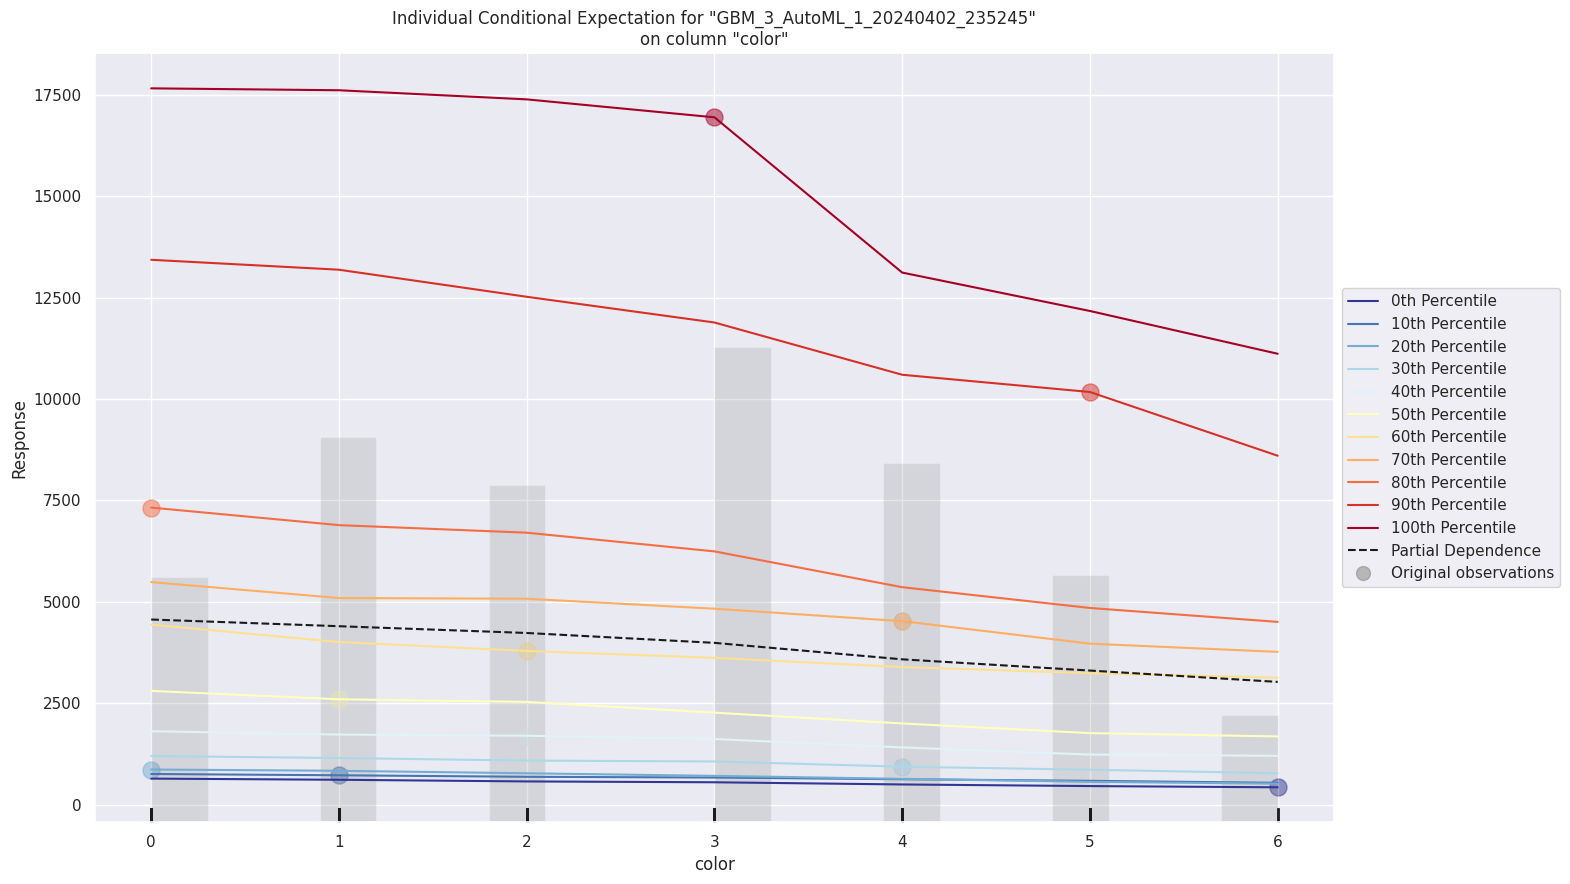

In [47]:
# H2O AutoML can show us a lot of information about the model explainability
# and it also compares the model with the other ones from the leaderboard
aml.explain(test);

## Shut down H2O cluster

In [48]:
# Remember to shut down H2O cluster
h2o.cluster().shutdown()

H2O session _sid_803d closed.


# Conclusions

Here are some conclusions about the diamonds dataset and the development and evaluation of a regression model:



*   Diamonds dataset

    - The dataset didn't have a lot of "dirty" data: no missing values, only 1 duplicated row, 11 inconsistent rows
    - The diamonds with the worst cut are the rarest, while the diamonds with the best cut are the most frequent kind in the dataset
    - In the dataset, there are no diamonds with a color that is better than J
    - Except for x, y and z, the numerical features and the target present a leptokurtic distribution
    - Except for depth, the numerical features and the target present tails on the right
    - We can see correlation between the following features and the target: carat, x, y, z

*   Regression model
    - H2O AutoML chose Gradient Boosting Machine as the best single model in the leaderboard
    - The model presents some overfitting, since the error grows on the test data
    - Overall, the model's predictions aren't so bad, the residual deviance is the lowest if compared to the other models in the leaderboard and the training time was very short
    - Simplicity was preferred to have more information about model explainability: we can conclude that the features carat, y and x (not only these) are very important for a diamond's price prediction.
